![image](https://github.com/Lexie88rus/steel_defect_detection/raw/master/assets/cover_large.png)

# EDA for Steel Defect Competition

## About the Competition

The production of flat steel is especially delicate. Today, Severstal uses images from high frequency cameras to power a defect detection algorithm.
Better __defect indentication with deep learning could make steel production more efficient__.

More information on steel defects can be found here:
[Use Machine Learning to Detect Defects on the Steel Surface](https://software.intel.com/en-us/articles/use-machine-learning-to-detect-defects-on-the-steel-surface) article with example images for each possible defect type.

In [1]:
# import basics
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from glob import glob

# import plotting
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib
import seaborn as sns

# import image manipulation
from PIL import Image
import imageio

! pip install --upgrade imgaug

# import data augmentation
import imgaug as ia
from imgaug import augmenters as iaa
# import segmentation maps from imgaug
from imgaug.augmentables.segmaps import SegmentationMapOnImage
import imgaug.imgaug

     |████████████████████████████████| 829kB 4.8MB/s 
ERROR: albumentations 0.3.3 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.3.0 which is incompatible.
  Found existing installation: imgaug 0.2.6
    Uninstalling imgaug-0.2.6:
      Successfully uninstalled imgaug-0.2.6


## Load Data

Define train and test paths and explore train and test sets:

In [2]:
# set paths to train and test image datasets
TRAIN_PATH = '../input/severstal-steel-defect-detection/train_images/'
TEST_PATH = '../input/severstal-steel-defect-detection/test_images/'

# load dataframe with train labels
train_df = pd.read_csv('../input/severstal-steel-defect-detection/train.csv')
train_fns = sorted(glob(TRAIN_PATH + '*.jpg'))
test_fns = sorted(glob(TEST_PATH + '*.jpg'))

print('There are {} images in the train set.'.format(len(train_fns)))
print('There are {} images in the test set.'.format(len(test_fns)))

There are 12568 images in the train set.
There are 1801 images in the test set.


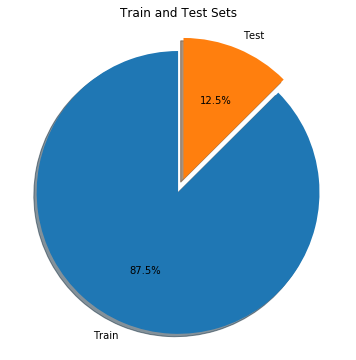

In [3]:
# plotting a pie chart which demonstrates train and test sets
labels = 'Train', 'Test'
sizes = [len(train_fns), len(test_fns)]
explode = (0, 0.1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Train and Test Sets')

plt.show()

Explore the `train.csv` file:

In [4]:
train_df.head(10)

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN
5,00031f466.jpg_2,NaN
6,00031f466.jpg_3,NaN
7,00031f466.jpg_4,NaN
8,000418bfc.jpg_1,NaN
9,000418bfc.jpg_2,NaN


`train.csv` file contains:
* __4 rows__ for each image from the train set. Each row corresponds to one of the defect labels.
* `ImageId_ClassId` is a combination of an image filename and the defect label.
* `EncodedPixels` column contains RLE encoded mask for the particular defect type or is empty, when the defect is not found.

## Explore Labels and Masks

`1` Explore empty masks:

In [5]:
print('There are {} rows with empty segmentation maps.'.format(len(train_df) - train_df.EncodedPixels.count()))

There are 43177 rows with empty segmentation maps.


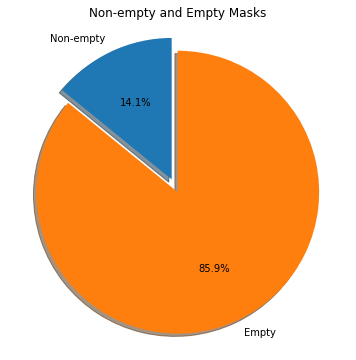

In [6]:
# plotting a pie chart
labels = 'Non-empty', 'Empty'
sizes = [train_df.EncodedPixels.count(), len(train_df) - train_df.EncodedPixels.count()]
explode = (0, 0.1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Non-empty and Empty Masks')

plt.show()

`2` Explore the labels:

At first, I would like to split the 1st column:

In [7]:
# split column
split_df = train_df["ImageId_ClassId"].str.split("_", n = 1, expand = True)

# add new columns to train_df
train_df['Image'] = split_df[0]
train_df['Label'] = split_df[1]

# check the result
train_df.head()

,ImageId_ClassId,EncodedPixels,Image,Label
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4
4,00031f466.jpg_1,NaN,00031f466.jpg,1


Analyse the number of labels for each defect type:

In [8]:
defect1 = train_df[train_df['Label'] == '1'].EncodedPixels.count()
defect2 = train_df[train_df['Label'] == '2'].EncodedPixels.count()
defect3 = train_df[train_df['Label'] == '3'].EncodedPixels.count()
defect4 = train_df[train_df['Label'] == '4'].EncodedPixels.count()

labels_count = train_df.groupby('Image').count()['EncodedPixels']
no_defects = len(labels_count) - labels_count.sum()

print('There are {} defect1 images'.format(defect1))
print('There are {} defect2 images'.format(defect2))
print('There are {} defect3 images'.format(defect3))
print('There are {} defect4 images'.format(defect4))
print('There are {} images with no defects'.format(no_defects))

There are 897 defect1 images
There are 247 defect2 images
There are 5150 defect3 images
There are 801 defect4 images
There are 5473 images with no defects


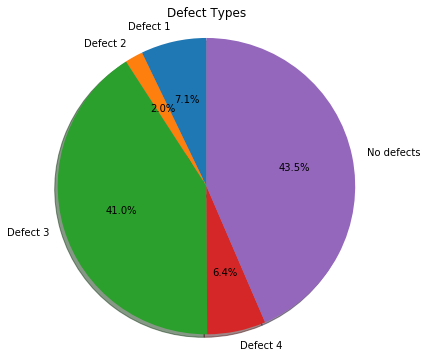

In [9]:
# plotting a pie chart
labels = 'Defect 1', 'Defect 2', 'Defect 3', 'Defect 4', 'No defects'
sizes = [defect1, defect2, defect3, defect4, len(train_fns) - defect1 - defect2 - defect3 - defect4]

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Defect Types')

plt.show()

__Conclusions:__
* The __dataset is very imbalanced.__
* Data augmentation and resampling techniques will be required to perform the defect detection.

In [10]:
labels_per_image = train_df.groupby('Image')['EncodedPixels'].count()
print('The mean number of labels per image is {}'.format(labels_per_image.mean()))

The mean number of labels per image is 0.564528962444303


Text(0.5, 1.0, 'Number of Labels per Image')

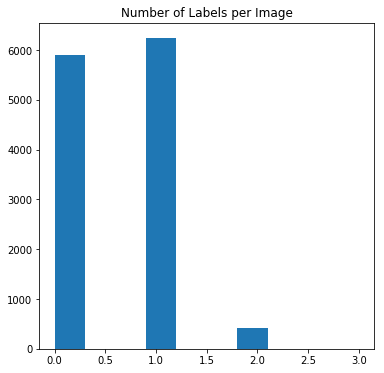

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(labels_per_image)
ax.set_title('Number of Labels per Image')

__Conclusions:__
* Almost half of images doesn't contain any defects;
* __Most of images with defects contain the defects of only one type__;
* In rare cases an image contains the defects of two different types.

## Analyze Images

`1.` Explore the image sizes:

In [12]:
def get_image_sizes(train = True):
    '''
    Function to get sizes of images from test and train sets.
    INPUT:
        train - indicates whether we are getting sizes of images from train or test set
    '''
    if train:
        path = TRAIN_PATH
    else:
        path = TEST_PATH
        
    widths = []
    heights = []
    
    images = sorted(glob(path + '*.jpg'))
    
    max_im = Image.open(images[0])
    min_im = Image.open(images[0])
        
    for im in range(0, len(images)):
        image = Image.open(images[im])
        width, height = image.size
        
        if len(widths) > 0:
            if width > max(widths):
                max_im = image

            if width < min(widths):
                min_im = image

        widths.append(width)
        heights.append(height)
        
    return widths, heights, max_im, min_im

In [13]:
# get sizes of images from test and train sets
train_widths, train_heights, max_train, min_train = get_image_sizes(train = True)
test_widths, test_heights, max_test, min_test = get_image_sizes(train = False)

print('Maximum width for training set is {}'.format(max(train_widths)))
print('Minimum width for training set is {}'.format(min(train_widths)))
print('Maximum height for training set is {}'.format(max(train_heights)))
print('Minimum height for training set is {}'.format(min(train_heights)))

Maximum width for training set is 1600
Minimum width for training set is 1600
Maximum height for training set is 256
Minimum height for training set is 256


In [14]:
print('Maximum width for test set is {}'.format(max(test_widths)))
print('Minimum width for test set is {}'.format(min(test_widths)))
print('Maximum height for test set is {}'.format(max(test_heights)))
print('Minimum height for test set is {}'.format(min(test_heights)))

Maximum width for test set is 1600
Minimum width for test set is 1600
Maximum height for test set is 256
Minimum height for test set is 256


__Conclusions:__
* We see that all images have the same size.

`2.` Visualize masks:

Utility function to create the mask from RLE (I borrowed the implementation from [this kernel](https://www.kaggle.com/titericz/building-and-visualizing-masks)):

In [15]:
# https://www.kaggle.com/titericz/building-and-visualizing-masks
def rle2maskResize(rle):
    # CONVERT RLE TO MASK 
    if (pd.isnull(rle))|(rle=='')|(rle=='-1'): 
        return np.zeros((256,1600) ,dtype=np.uint8)
    
    height= 256
    width = 1600
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
    
    return mask.reshape( (height,width), order='F' )

In [16]:
def plot_mask(image_filename):
    '''
    Function to plot an image and segmentation masks.
    INPUT:
        image_filename - filename of the image (with full path)
    '''
    img_id = image_filename.split('/')[-1]
    image = Image.open(image_filename)
    train = train_df.fillna('-1')
    rle_masks = train[(train['Image'] == img_id) & (train['EncodedPixels'] != '-1')]['EncodedPixels'].values
    
    defect_types = train[(train['Image'] == img_id) & (train['EncodedPixels'] != '-1')]['Label'].values
    
    if (len(rle_masks) > 0):
        fig, axs = plt.subplots(1, 1 + len(rle_masks), figsize=(20, 3))

        axs[0].imshow(image)
        axs[0].axis('off')
        axs[0].set_title('Original Image')

        for i in range(0, len(rle_masks)):
            mask = rle2maskResize(rle_masks[i])
            axs[i + 1].imshow(image)
            axs[i + 1].imshow(mask, alpha = 0.5, cmap = "Reds")
            axs[i + 1].axis('off')
            axs[i + 1].set_title('Mask with defect #{}'.format(defect_types[i]))

        plt.suptitle('Image with defect masks')
    else:
        fig, axs = plt.subplots(figsize=(20, 3))
        axs.imshow(image)
        axs.axis('off')
        axs.set_title('Original Image without Defects')

Plot some image and masks examples:

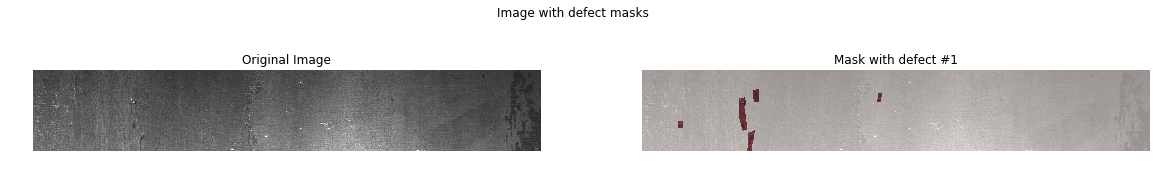

In [17]:
# plot image with single defect
plot_mask(train_fns[0])

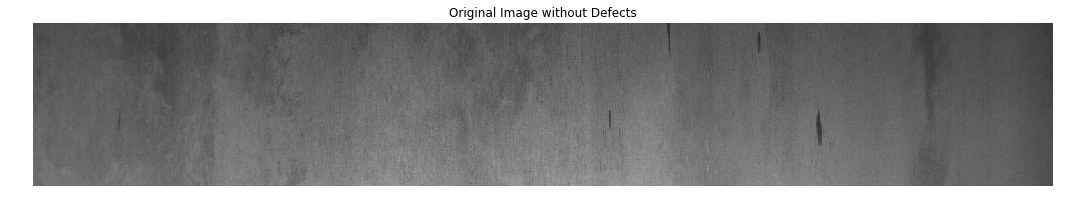

In [18]:
# plot image without defects
plot_mask(train_fns[1])

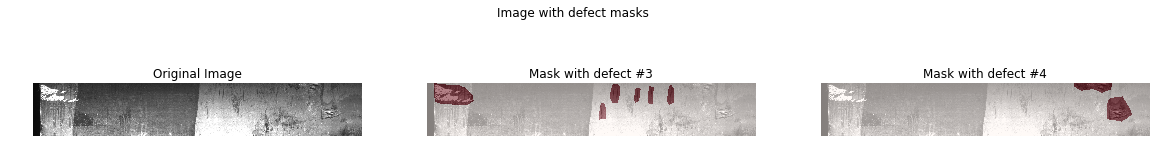

In [19]:
# plot image example with several defects
for image_code in train_df.Image.unique():
    if (train_df.groupby(['Image'])['EncodedPixels'].count().loc[image_code] > 1):
        plot_mask(TRAIN_PATH + image_code)
        break;

`3.` Analyze mask area sizes

In [20]:
def get_mask(line_id):
    '''
    Function to visualize the image and the mask.
    INPUT:
        line_id - id of the line to visualize the masks
    RETURNS:
        np_mask - numpy segmentation map
    '''
    
    # convert rle to mask
    rle = train_df.loc[line_id]['EncodedPixels']
    
    np_mask = rle2maskResize(rle)
    np_mask = np.clip(np_mask, 0, 1)
        
    return np_mask

def add_mask_areas(train_df):
    '''
    Helper function to add mask area as a new column to the dataframe
    INPUT:
        train_df - dataset with training labels
    '''
    masks_df = train_df.copy()
    masks_df['Area'] = 0
        
    for i, row in masks_df.iterrows():
        masks_df['Area'].loc[i] = np.sum(get_mask(i))
    
    return masks_df

In [21]:
masks_df = add_mask_areas(train_df)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


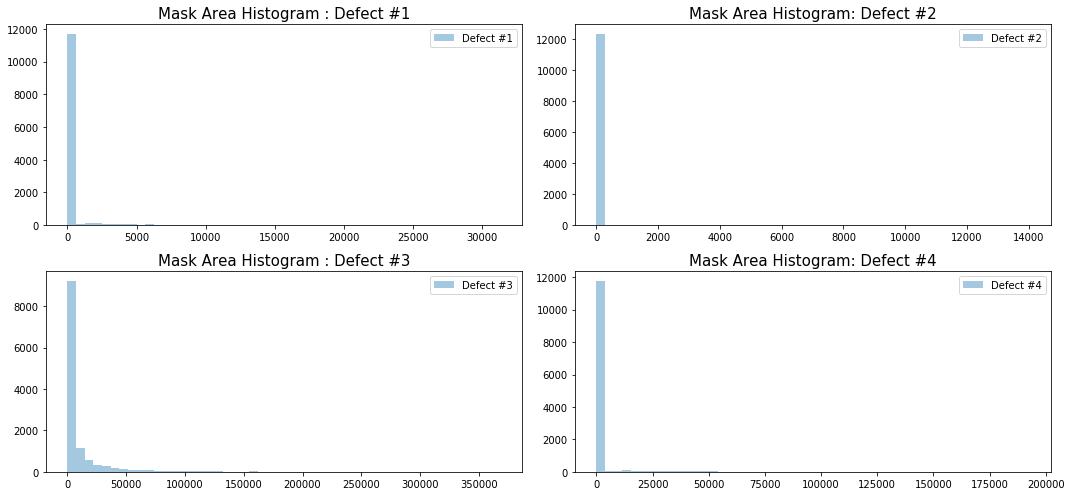

In [22]:
# Plot Histograms and KDE plots
plt.figure(figsize=(15,7))

plt.subplot(221)
sns.distplot(masks_df[masks_df['Label'] == '1']['Area'].values, kde=False, label='Defect #1')
plt.legend()
plt.title('Mask Area Histogram : Defect #1', fontsize=15)

plt.subplot(222)
sns.distplot(masks_df[masks_df['Label'] == '2']['Area'].values, kde=False, label='Defect #2')
plt.legend()
plt.title('Mask Area Histogram: Defect #2', fontsize=15)

plt.subplot(223)
sns.distplot(masks_df[masks_df['Label'] == '3']['Area'].values, kde=False, label='Defect #3')
plt.legend()
plt.title('Mask Area Histogram : Defect #3', fontsize=15)

plt.subplot(224)
sns.distplot(masks_df[masks_df['Label'] == '4']['Area'].values, kde=False, label='Defect #4')
plt.legend()
plt.title('Mask Area Histogram: Defect #4', fontsize=15)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Mask Area KDE Plot')

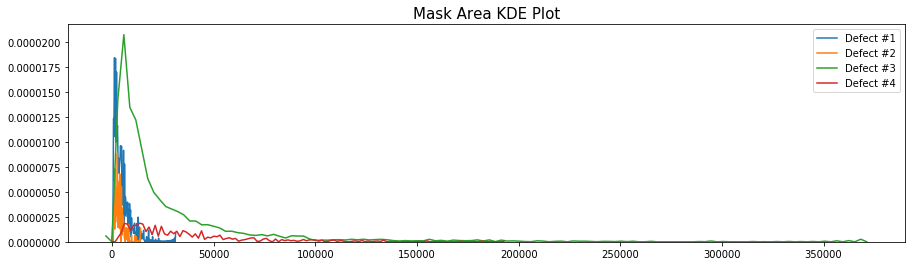

In [23]:
plt.figure(figsize=(15,4))

plt.subplot(111)
sns.kdeplot(masks_df[masks_df['Label'] == '1']['Area'].values, label='Defect #1')
sns.kdeplot(masks_df[masks_df['Label'] == '2']['Area'].values, label='Defect #2')
sns.kdeplot(masks_df[masks_df['Label'] == '3']['Area'].values, label='Defect #3')
sns.kdeplot(masks_df[masks_df['Label'] == '4']['Area'].values, label='Defect #4')
plt.legend()

plt.title('Mask Area KDE Plot', fontsize=15)

Masks with large areas seem very suspicious to me, so I will try to plot several examples of images with large mask areas picked by random index:

In [24]:
def plot_image_grid(df, n_images = 5):
    
    fig, axs = plt.subplots(n_images, 2, figsize=(20, 10))
    
    for i in range(n_images):
        image_id = np.random.randint(0,len(df),1)[0]

        image = Image.open(TRAIN_PATH + df.iloc[image_id]['Image'])
        mask = rle2maskResize(df.iloc[image_id]['EncodedPixels'])
        
        defect = df.iloc[image_id]['Label']

        axs[i,0].imshow(image)
        axs[i,0].axis('off')
        axs[i,0].set_title('Original Image')

        axs[i, 1].imshow(image)
        axs[i, 1].imshow(mask, alpha = 0.5, cmap = "Reds")
        axs[i, 1].axis('off')
        axs[i, 1].set_title('Mask with defect #{}'.format(defect))

    plt.suptitle('Images with defect masks')

In [25]:
# filter the dataframe, so we have only images with very large masks
large_masks_df = masks_df[masks_df['Area'] > 200000]

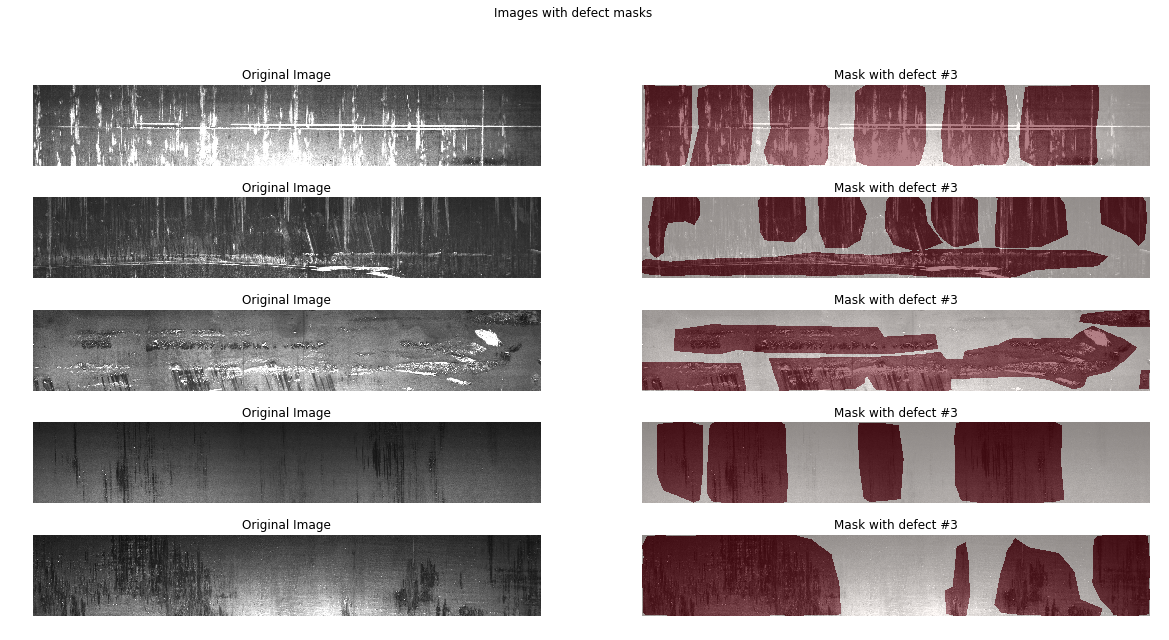

In [26]:
# plot a grid of images with large masks
plot_image_grid(large_masks_df, n_images = 5)

Large masks seem to be okay, except for the fact that these masks seem to contain a lot of empty space without any defects

`4.` Analyze the number of masks per image:

In [27]:
from scipy.ndimage import label, generate_binary_structure

def add_mask_number(train_df):
    '''
    Helper function to add mask area as a new column to the dataframe
    INPUT:
        train_df - dataset with training labels
    '''
    masks_df = train_df.copy()
    masks_df['NumMasks'] = 0
    
    s = generate_binary_structure(2,2)
        
    for i, row in masks_df.iterrows():
        mask = get_mask(i)
        
        if np.sum(mask) > 0:
            labeled_array, labels = label(mask, structure=s)
            masks_df['NumMasks'].loc[i] = labels
        else:
            masks_df['NumMasks'].loc[i] = 0
    
    return masks_df

In [28]:
masks_df = add_mask_number(masks_df)

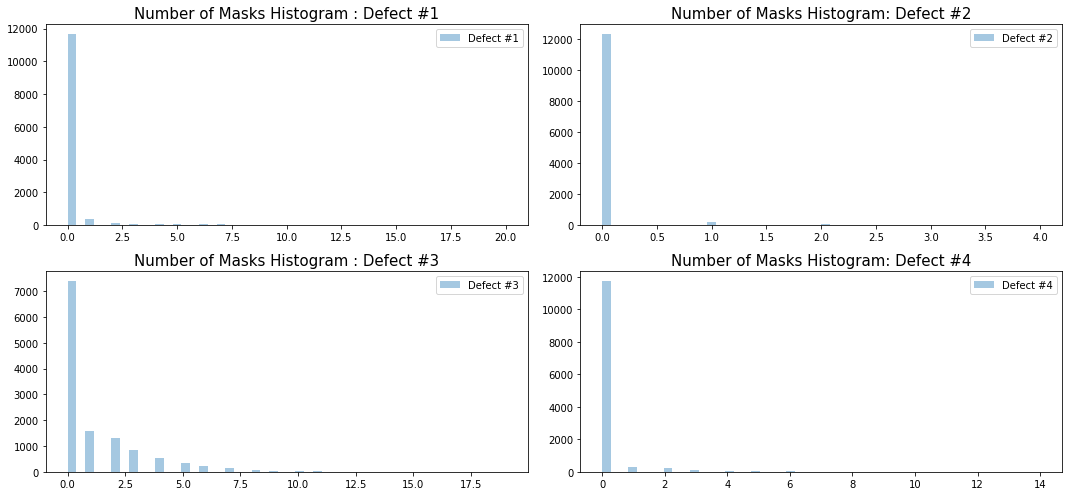

In [29]:
# Plot Histograms and KDE plots
plt.figure(figsize=(15,7))

plt.subplot(221)
sns.distplot(masks_df[masks_df['Label'] == '1']['NumMasks'].values, kde=False, label='Defect #1')
plt.legend()
plt.title('Number of Masks Histogram : Defect #1', fontsize=15)

plt.subplot(222)
sns.distplot(masks_df[masks_df['Label'] == '2']['NumMasks'].values, kde=False, label='Defect #2')
plt.legend()
plt.title('Number of Masks Histogram: Defect #2', fontsize=15)

plt.subplot(223)
sns.distplot(masks_df[masks_df['Label'] == '3']['NumMasks'].values, kde=False, label='Defect #3')
plt.legend()
plt.title('Number of Masks Histogram : Defect #3', fontsize=15)

plt.subplot(224)
sns.distplot(masks_df[masks_df['Label'] == '4']['NumMasks'].values, kde=False, label='Defect #4')
plt.legend()
plt.title('Number of Masks Histogram: Defect #4', fontsize=15)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Number of masks KDE Plot')

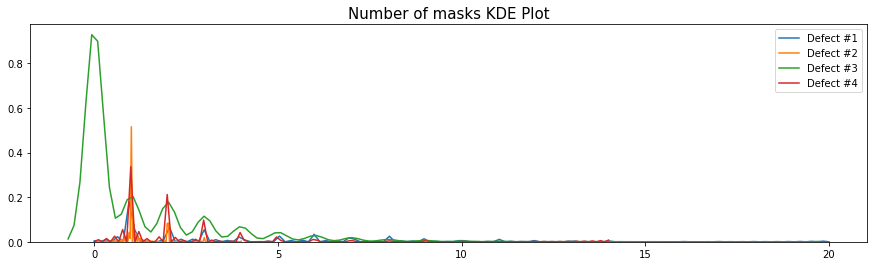

In [30]:
plt.figure(figsize=(15,4))

plt.subplot(111)
sns.kdeplot(masks_df[masks_df['Label'] == '1']['NumMasks'].values, label='Defect #1')
sns.kdeplot(masks_df[masks_df['Label'] == '2']['NumMasks'].values, label='Defect #2')
sns.kdeplot(masks_df[masks_df['Label'] == '3']['NumMasks'].values, label='Defect #3')
sns.kdeplot(masks_df[masks_df['Label'] == '4']['NumMasks'].values, label='Defect #4')
plt.legend()

plt.title('Number of masks KDE Plot', fontsize=15)

Visualize the images with plenty of masks:

In [31]:
# filter the dataframe, so we have only images with very large masks
many_masks_df = masks_df[masks_df['NumMasks'] > 15]

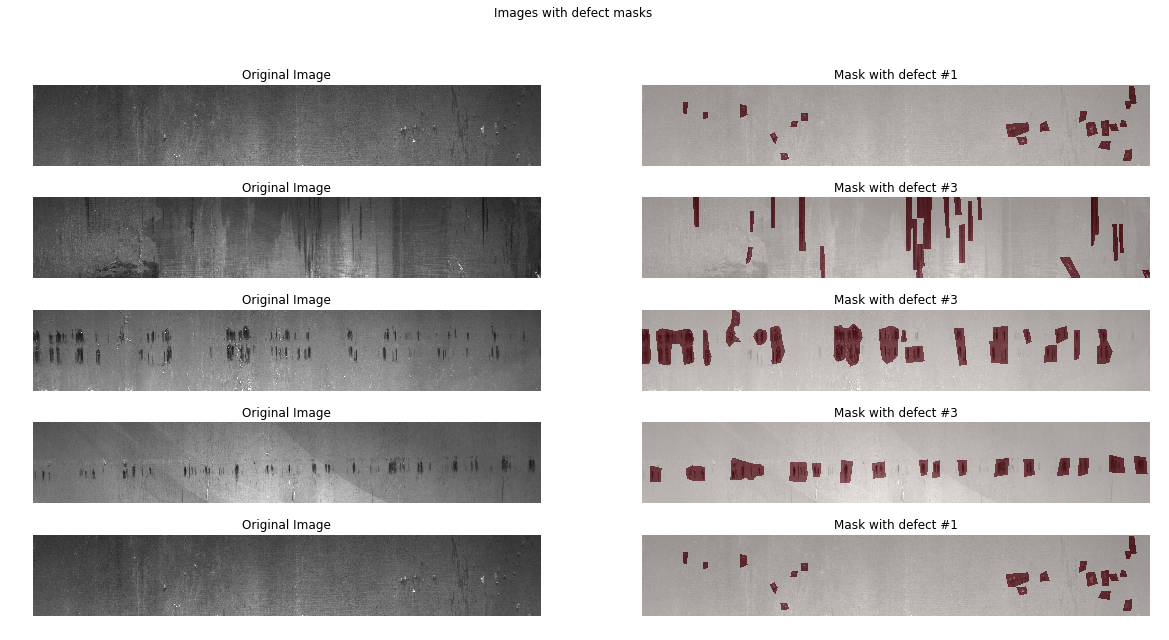

In [32]:
plot_image_grid(many_masks_df, n_images = 5)

Comparing to the images with large area masks, I can say that in this competition we are probably dealing with __inconsistent masking__:
* Some images contain precisely cropped defects with very small empty space amount.
* Some images contain large masks with both large defect and empty space areas.

I added some helper code to __view only the edges of the masks__:

In [33]:
from scipy.ndimage.morphology import binary_dilation, binary_erosion, binary_opening

def get_mask_edges(mask):
    
    s = generate_binary_structure(2,2)
    
    mask = mask - binary_erosion(mask, structure = s)
    mask = binary_dilation(binary_dilation(mask, structure = s))
    
    return mask

def plot_image_grid_edges(df, n_images = 5):
    
    fig, axs = plt.subplots(n_images, 2, figsize=(20, 10))
    
    for i in range(n_images):
        image_id = np.random.randint(0,len(df),1)[0]

        image = Image.open(TRAIN_PATH + df.iloc[image_id]['Image'])
        mask = rle2maskResize(df.iloc[image_id]['EncodedPixels'])
        
        mask = get_mask_edges(mask)
        
        defect = df.iloc[image_id]['Label']

        axs[i,0].imshow(image)
        axs[i,0].axis('off')
        axs[i,0].set_title('Original Image')

        axs[i, 1].imshow(image)
        axs[i, 1].imshow(mask, alpha = 0.5, cmap = "Reds")
        axs[i, 1].axis('off')
        axs[i, 1].set_title('Mask with defect #{}'.format(defect))

    plt.suptitle('Images with defect masks')

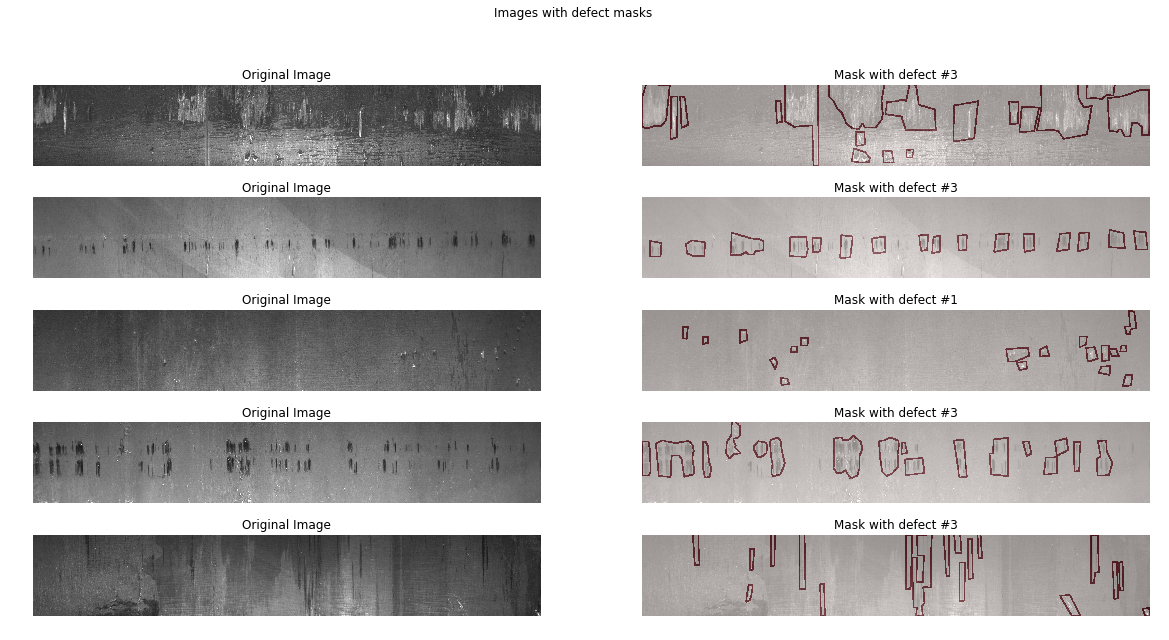

In [34]:
plot_image_grid_edges(many_masks_df, n_images = 5)

`5.` Add some data augmentation:

I would also like to demosnstrate how it is possible to apply the data augmentation from __imgaug__ library for the images (see the example [here](https://imgaug.readthedocs.io/en/latest/source/examples_basics.html)):

/opt/conda/lib/python3.6/site-packages/imgaug/imgaug.py:182: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)
/opt/conda/lib/python3.6/site-packages/imgaug/imgaug.py:182: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/opt/conda/lib/python3.6/site-packages/imgaug/imgaug.py:107: DeprecationWarning: Providing nb_classes to SegmentationMapsOnImage is no longer necessary and hence deprecated. The argument is ignored and can be safely removed.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


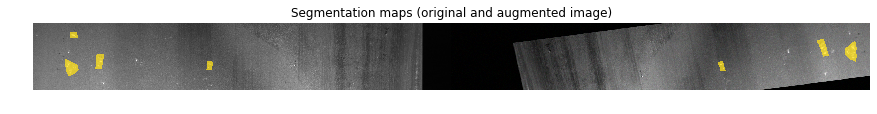

In [35]:
ia.seed(31)
np.random.seed(27240)

# initialize augmentations
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.ContrastNormalization((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

# generate random index for an image
rnd_index = np.random.choice(range(len(train_df) // 4)) * 4

# open the image
image = np.asarray(Image.open(TRAIN_PATH + train_df.iloc[rnd_index]['Image']))

# get masks for different classes
mask_1 = rle2maskResize(train_df.iloc[rnd_index]['EncodedPixels'])
mask_2 = rle2maskResize(train_df.iloc[rnd_index + 1]['EncodedPixels'])
mask_3 = rle2maskResize(train_df.iloc[rnd_index + 2]['EncodedPixels'])
mask_4 = rle2maskResize(train_df.iloc[rnd_index + 3]['EncodedPixels'])

# label numpy map with 4 classes
segmap = np.zeros((image.shape[0], image.shape[1]), dtype=np.int32)
segmap = np.where(mask_1 == 1, 1, segmap)
segmap = np.where(mask_2 == 1, 2, segmap)
segmap = np.where(mask_3 == 1, 3, segmap)
segmap = np.where(mask_4 == 1, 4, segmap)

# create a segmantation map
segmap = SegmentationMapOnImage(segmap, shape=image.shape, nb_classes=5)

# apply augmentation for image and mask
image_aug, segmap_aug = seq(image=np.asarray(image), segmentation_maps=segmap)

# visualize the image and map
side_by_side = np.hstack([
    np.asarray(segmap.draw_on_image(image)).reshape(np.asarray(image).shape),
    np.asarray(segmap_aug.draw_on_image(image_aug)).reshape(np.asarray(image).shape)
])

fig, ax = plt.subplots(figsize=(15, 7))
ax.axis('off')
plt.title('Segmentation maps (original and augmented image)')

ax.imshow(side_by_side)

**Conclusions:**
1. From the plots we can see that the defect 3 is the most common defect found on steel images.
2. Defects type 2 and 4 are very rare, but there are often multiple masks with this defect on a single image.

## Conclusions:
In this kernel I:
* Explored the number of samples in train and test sets.
* Explored the number of training samples for each defect class.
* Visualized the examples of defects.
* Analyzed mask areas and number masks for each defect type.

__Your comments and suggestions on how to improve this kernel are highly appreciated!__

## References
1. [Kaggle kernel](https://www.kaggle.com/titericz/building-and-visualizing-masks) on building and visualizing masks.
2. [My EDA for Cloud competition](https://www.kaggle.com/aleksandradeis/understanding-clouds-eda) with similar code.
3. [imgaug](https://imgaug.readthedocs.io/en/latest/source/examples_basics.html) documentation.

## Revision History:
1. The initial public version.
2. Added visualization of images with large mask areas and with many masks.
3. Added the example of simple data augmentation pipeline.
4. Corrected small issues.
5. Added helper function to view only edges of defect masks.